# Импорт библиотек

In [2]:
%pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [1]:
%pip install sentencepiece datasets

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [3]:
%pip install -q accelerate peft bitsandbytes transformers trl tensorflow

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:
%pip install fsspec==2023.6.0 s3fs==2023.6.0

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np
import string, re
from collections import Counter

from gspread import authorize
import pandas as pd

from oauth2client.service_account import ServiceAccountCredentials

scopes = ["https://spreadsheets.google.com/feeds",
                  "https://www.googleapis.com/auth/spreadsheets",
                  "https://www.googleapis.com/auth/drive",
                  "https://www.googleapis.com/auth/drive"]


In [2]:
from typing import List  # 👉 Importing the List type from the typing module
import numpy as np  # 👉 Importing the NumPy library and aliasing it as np
import pandas as pd  # 👉 Importing the Pandas library and aliasing it as pd
import warnings  # 👉 Importing the warnings module
import logging  # 👉 Importing the logging module
import os  # 👉 Importing the os module
import shutil  # 👉 Importing the shutil module
import json  # 👉 Importing the json module
import transformers  # 👉 Importing the transformers library
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification  # 👉 Importing specific classes from transformers
from transformers import DataCollatorWithPadding  # 👉 Importing the DataCollatorWithPadding class from transformers
from transformers import TrainingArguments, Trainer  # 👉 Importing specific classes from transformers
from sklearn.metrics import mean_squared_error  # 👉 Importing the mean_squared_error function from scikit-learn
import torch  # 👉 Importing the torch library
from sklearn.model_selection import KFold, GroupKFold  # 👉 Importing KFold and GroupKFold classes from scikit-learn
from tqdm import tqdm  # 👉 Importing the tqdm function from the tqdm module

from datasets import Dataset
import nltk  # 👉 Importing the nltk library
from nltk.corpus import stopwords  # 👉 Importing the stopwords corpus from nltk
from nltk.tokenize import word_tokenize  # 👉 Importing the word_tokenize function from nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer  # 👉 Importing the TreebankWordDetokenizer class from nltk
from collections import Counter  # 👉 Importing the Counter class from the collections module
import spacy  # 👉 Importing the spacy library
import re  # 👉 Importing the re module
# from autocorrect import Speller  # 👉 Importing the Speller class from autocorrect
# from spellchecker import SpellChecker  # 👉 Importing the SpellChecker class from spellchecker
import lightgbm as lgb  # 👉 Importing the lightgbm library and aliasing it as lgb

warnings.simplefilter("ignore")  # 👉 Ignore warnings in the code
logging.disable(logging.ERROR)  # 👉 Disable logging to ERROR level
# os.environ["TOKENIZERS_PARALLELISM"] = "false"  # 👉 Set an environment variable for tokenizers
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 👉 Set the minimum Tensorflow log level to 3
# disable_progress_bar()  # 👉 Disable progress bars

import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel, get_peft_model
from trl import SFTTrainer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


tqdm.pandas()  # 👉 Enable tqdm progress bars

nltk.download('stopwords')
nltk.download('punkt')

2024-01-06 17:18:10.253480: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Define a class for configuration settings
class CFG:
    model_name = "NousResearch/Llama-2-7b-chat-hf"  # Model name for reference
    learning_rate = 2e-4 # Learning rate 📚
    weight_decay = 0.001  # Weight decay (L2 regularization) 🏋️‍♂️
    #hidden_dropout_prob = 0.007  # Dropout probability for hidden layers 🙈
    #attention_probs_dropout_prob = 0.007  # Dropout probability for attention layers 🙉
    num_train_epochs = 30  # Number of training epochs 🚂
    n_splits = 2  # Number of splits for cross-validation 🔄
    batch_size = 4  # Batch size for training data 📦
    random_seed = 42  # Random seed for reproducibility 🌱
    save_steps = 100  # Number of steps before saving model checkpoints 📥
    max_length = 250  # Maximum sequence length for input data 📏

TARGET = "Solving a communicative task"

In [4]:
def display_confusion_matrix(y_true, y_pred, model_name: str) -> None:

  confusion_matrix_data = confusion_matrix(y_true, y_pred)

  plt.figure(figsize=(8,8))
  cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_data, display_labels=sorted(y_true.unique()))
  cm_display.plot()
  plt.title(model_name)
  plt.show()

def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=42)

# Чтение и очистка данных

In [5]:
def read_from_gsheet():
    cred = ServiceAccountCredentials.from_json_keyfile_name('./credentials_googlesheets.json', scopes)
    gc = authorize(cred)
    sheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1m0mc1H7ULIZ2HEkT4dha_XRmRjt0gWJ8aht_GJ2lxfw/edit#gid=0')
    ws = sheet.worksheet('Dataset')
    return pd.DataFrame(ws.get_all_records())

def drop_unwanted_data(df: pd.DataFrame):
    columns_to_drop = ['Comments', 'origin', 'task_image', 'score_image']
    columns = ['Solving a communicative task', 'Text structure', 'Use of English (for emails)', 'Lexis (essay)',
               'Grammatical accuracy (essay)', 'Punctuation and spelling (essay)']

    # Удаляем лишние столбцы (на данный момент)
    df = df.drop(columns=columns_to_drop)

    # Удаляем строки баллов, если там сожержатся другие значения, кроме int и float (избавимся от string)
    for column in columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')

    return df

def split_types(df: pd.DataFrame):
    # Следующий этап - разделим на письма и эссе
    essay_df = df[df[' Type'] == 'Essay']
    email_df = df[df[' Type'] == 'Email']

    # и удалим лишние колонки для каждого типа
    essay_df = essay_df.drop(columns='Use of English (for emails)')
    email_df = email_df.drop(
        columns=['Lexis (essay)', 'Grammatical accuracy (essay)', 'Punctuation and spelling (essay)'])

    # Убираем NaN
    essay_df = essay_df.dropna()
    email_df = email_df.dropna()

    return essay_df, email_df


In [6]:
# Читаем данные из таблицы, удаляем неинтересующие столбцы, фильтруем по типу задания
raw_data = read_from_gsheet()
_, email_data = split_types(raw_data)

## Добавление сгенерированных данных

In [7]:
gpt_data = pd.read_excel("./263_emails_paraphrased.xlsx")
gpt_data.columns = ["Question", "Text", "GPT_Text"]
gpt_data["Solving a communicative task"] = 1
# gpt_data["Question"] = gpt_data.merge(email_data, on="Text")["Question"]

In [8]:
gpt_data = gpt_data.drop('Text', axis=1).rename(columns={'GPT_Text':'Text'})

In [9]:
gpt_data["Text"] = gpt_data["Text"].replace({"\s+Explanation?([\s\S]*)": "", ".*\w+\s+[Qq]uestions?([\s\S]*)": "", "\s+\---?([\s\S]*)": "", 
                                             ".*\w+\s+[Ll]etter?([\s\S]*)": ""}, regex=True)

In [10]:
email_data = pd.concat([gpt_data, email_data], ignore_index=True, axis=0)

## Question preprocessing

In [11]:
def get_main_section(s):
  text = re.search(r"Subject:([\s\S]*?)Write an? e-?mail", s)
  if text is not None:
    return text.group(1)
  else:
    return None

def rm_after_write_phrase(s):
  text = re.sub(r"Write an? e-?mail[\s\S]*", "", s)
  return text

def get_after_newline(s):
  text = re.search("\n[\s\S]*", s)
  if text is not None:
    return text.group()
  else:
    print(s)
    return None

# def rm_dots(s):
#   text = re.sub(r"\.{2,}|…", "", s)
#   return text

def trim_questions(raw: pd.Series) -> pd.Series:
  full_questions = raw[raw.str.contains('You have received an email message')]
  trimmed_questions = full_questions.apply(get_main_section)
  trimmed_questions = trimmed_questions.str.replace("\n+", "\n", regex=True).str.strip()
  trimmed_questions = trimmed_questions.apply(get_after_newline)
  return trimmed_questions

In [12]:
# Обрежем условия заданий, оставив только часть с вопросами и предложение для ответа на вопрос
trimmed_questions = trim_questions(email_data["Question"]) 
email_data.loc[trimmed_questions.index, "Question"] = trimmed_questions

In [13]:
# Очистим ненужные символы и преобразуем к строчному регистру
initial_questions_indx = email_data.index.difference(trimmed_questions.index)
email_data.loc[initial_questions_indx, "Question"] = email_data.loc[initial_questions_indx, "Question"].apply(rm_after_write_phrase)
email_data["Question"] = email_data["Question"].str.replace("[^A-Za-z\s-]", " ", regex=True).apply(lambda x: " ".join(x.split())).str.lower().str.strip()

## Фильтрация датасета

In [14]:
email_data = email_data[email_data['Text'].str.strip().astype(bool)] # Удалим строки с пустыми ответами
email_data = email_data[email_data['Overall_score'] != 0]
email_data = email_data[~email_data['Question'].str.contains('[А-Яа-я]+', regex=True)]
email_data = email_data[email_data['Question'].notna()]
email_data = email_data[email_data['Question'] != '']
email_data["Text"] = email_data["Text"].apply(lambda x: re.sub(r'[^A-Za-z\s]', ' ', str(x)))

In [15]:
score_columns = ['Solving a communicative task']
for score_col in score_columns:
    email_data = email_data[pd.to_numeric(email_data[score_col], errors='coerce').notna()]
    email_data[score_col] = email_data[score_col].astype(np.float16)

In [16]:
email_data["Solving a communicative task"].value_counts()

2.0    343
1.0    332
0.0      3
Name: Solving a communicative task, dtype: int64

In [18]:
train = email_data.reset_index(drop=True)

In [19]:
# Create a GroupKFold object with the specified number of splits
gkf = GroupKFold(n_splits=CFG.n_splits)
groups = train["Question"]
# Iterate through the splits and assign fold numbers to validation data
for i, (_, val_index) in enumerate(gkf.split(train, groups=groups)):
    train.loc[val_index, "fold"] = i

# Display the first few rows of the training data with fold assignments
train.head()

,Question,Text,Solving a communicative task,Type,Question id,Text structure,Use of English (for emails),Comments,Overall_score,origin,task_image,score_image,fold
0,in great britain young people want to become i...,Hey Tom \n\nThanks for your message It was re...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,summer is coming and i want to look my best he...,Dear Mary \n\nThank you for your message and ...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,my mum often complains that i spend too much m...,Dear Andrea \n\nThank you for your message an...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,summer is coming and i want to look my best he...,Dear Mary \n\nThank you for your message and ...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,i m currently studying for my exams and hope t...,Dear Richard \n\nThank you for your message a...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [20]:
# Define a function to compute root mean squared error (RMSE)
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Calculate RMSE
    rmse = mean_squared_error(labels, predictions, squared=False)

    # Return RMSE as a dictionary
    return {"rmse": rmse}

# Создание класса модели и обучение

In [21]:
# Define a class for the Content Score Regressor
class ContentScoreRegressor:
    def __init__(self,
                model_name: str,
                model_dir: str,
                target: str,
                # hidden_dropout_prob: float,
                # attention_probs_dropout_prob: float,
                max_length: int,
                ):
        # Define input columns and target column
        self.inputs = ["Question", "Text"]
        self.input_col = "input"
        self.text_cols = [self.input_col]
        self.target = target
        self.target_cols = [target]

        # Initialize model-related attributes
        self.model_name = model_name
        self.model_dir = model_dir
        self.max_length = max_length

        # Initialize tokenizer and model configuration
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model_config = AutoConfig.from_pretrained(model_name)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.padding_side = "right"

        # Update model configuration with additional parameters
        self.model_config.update({
            # "hidden_dropout_prob": hidden_dropout_prob,
            # "attention_probs_dropout_prob": attention_probs_dropout_prob,
            "num_labels": 1,
            "problem_type": "regression"
        })

        # Set a fixed random seed for reproducibility
        seed_everything(seed=42)

        # Initialize data collator for padding
        self.data_collator = DataCollatorWithPadding(
            tokenizer=self.tokenizer
        )

        self.bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=getattr(torch, "float16"),
            bnb_4bit_use_double_quant=False,
        )

        self.peft_config = LoraConfig(
            lora_alpha=16,
            lora_dropout=0.1,
            r=16,
            bias="none",
            task_type="SEQ_CLS",
        )

    def tokenize_function(self, examples: pd.DataFrame):
        labels = [examples[self.target]]
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return {
            **tokenized,
            "labels": labels,
        }

    def tokenize_function_test(self, examples: pd.DataFrame):
        tokenized = self.tokenizer(examples[self.input_col],
                         padding=False,
                         truncation=True,
                         max_length=self.max_length)
        return tokenized

    def train(self,
            fold: int,
            train_df: pd.DataFrame,
            valid_df: pd.DataFrame,
            batch_size: int,
            learning_rate: float,
            weight_decay: float,
            num_train_epochs: float,
            save_steps: int,
        ) -> None:
        """Fine-tuning the model"""

        # sep = self.tokenizer.sep_token

        # Create input text by concatenating title, question, and summary
        train_df[self.input_col] = (
                    train_df["Question"] + "\n\n"
                    + train_df["Text"]
                  )

        valid_df[self.input_col] = (
                    valid_df["Question"] + "\n\n"
                    + valid_df["Text"]
                  )

        # Select relevant columns for training and validation
        train_df = train_df[[self.input_col] + self.target_cols]
        valid_df = valid_df[[self.input_col] + self.target_cols]

        # Load the pre-trained model for content score prediction
        model_content = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            config=self.model_config,
            quantization_config=self.bnb_config,
            device_map = {"":0},
            trust_remote_code=True
        )
        model_content.config.pad_token_id = model_content.config.eos_token_id
        # model.config.pad_token_id = model.config.bos_token_id
        # print(model_content.config.pad_token_id)
        peft_model = get_peft_model(model_content, self.peft_config)

        # Create datasets from DataFrames
        train_dataset = Dataset.from_pandas(train_df, preserve_index=False)
        val_dataset = Dataset.from_pandas(valid_df, preserve_index=False)

        # Tokenize and preprocess the datasets
        train_tokenized_datasets = train_dataset.map(self.tokenize_function, batched=False)
        val_tokenized_datasets = val_dataset.map(self.tokenize_function, batched=False)

        # Define model training arguments
        model_fold_dir = os.path.join(self.model_dir, str(fold))
        training_args = TrainingArguments(
            output_dir=model_fold_dir,
            load_best_model_at_end=True,
            learning_rate=learning_rate,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            num_train_epochs=num_train_epochs,
            weight_decay=weight_decay,
            report_to='none',
            save_strategy="steps",
            evaluation_strategy="steps",
            eval_steps=save_steps,
            save_steps=save_steps,
            metric_for_best_model="rmse",
            lr_scheduler_type="cosine",
            warmup_ratio=0.1,
            max_grad_norm=0.3,
            fp16=False,
            bf16 = False,
            optim="paged_adamw_32bit"
        )

        # Create a trainer for model training
        trainer = Trainer(
            model=peft_model,
            args=training_args,
            train_dataset=train_tokenized_datasets,
            eval_dataset=val_tokenized_datasets,
            tokenizer=self.tokenizer,
            compute_metrics=compute_metrics,
            data_collator=self.data_collator,
            # peft_config=self.peft_config,
        )

        # Train the model
        trainer.train()

        # Save the trained model and tokenizer
        peft_model.save_pretrained(self.model_dir)
        self.tokenizer.save_pretrained(self.model_dir)


    def predict(self,
                test_df: pd.DataFrame,
                fold: int,
               ):
        """Predict content score for test data"""

        # sep = self.tokenizer.sep_token

        # Create input text for test data
        in_text = (
                    test_df["Question"] + "\n\n"
                    + test_df["Text"]
                  )
        test_df[self.input_col] = in_text

        # Select the relevant columns
        test_ = test_df[[self.input_col]]

        # Create a dataset from the test data
        test_dataset = Dataset.from_pandas(test_, preserve_index=False)
        test_tokenized_dataset = test_dataset.map(self.tokenize_function_test, batched=False)

        # Load the trained content score prediction model
        model_content = AutoModelForSequenceClassification.from_pretrained(
            self.model_dir,
            config=self.model_config,
            quantization_config=self.bnb_config,
            device_map = {"":0},
            trust_remote_code=True)
        # model_content.config.pad_token_id = model_content.config.eos_token_id
        # peft_model = get_peft_model(model_content, self.peft_config)
        model_content.eval()

        # Define model prediction arguments
        model_fold_dir = os.path.join(self.model_dir, str(fold))
        test_args = TrainingArguments(
            output_dir=model_fold_dir,
            do_train = False,
            do_predict = True,
            per_device_eval_batch_size = 4,
            dataloader_drop_last = False,
        )

        # Initialize a trainer for inference
        infer_content = Trainer(
                      model = model_content,
                      tokenizer=self.tokenizer,
                      data_collator=self.data_collator,
                      args = test_args)

        # Perform predictions
        preds = infer_content.predict(test_tokenized_dataset)[0]

        return preds



In [22]:
# Define a function for training by fold
def train_by_fold(
        train_df: pd.DataFrame,
        model_name: str,
        target: str,
        save_each_model: bool,
        n_splits: int,
        batch_size: int,
        learning_rate: int,
        # hidden_dropout_prob: float,
        # attention_probs_dropout_prob: float,
        weight_decay: float,
        num_train_epochs: int,
        save_steps: int,
        max_length: int
    ):

    model_basename = os.path.basename(model_name)

    # Delete old model files
    if os.path.exists(f"train_{model_basename}"):
        shutil.rmtree(f"train_{model_basename}")

    os.mkdir(f"train_{model_basename}")

    for fold in range(n_splits):
        print(f"fold {fold}:")

        train_data = train_df[train_df["fold"] != fold]
        valid_data = train_df[train_df["fold"] == fold]

        if save_each_model == True:
            model_dir =  f"{target}/{model_basename}/fold_{fold}"
        else:
            model_dir =  f"train_{model_basename}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir=model_dir,
            # hidden_dropout_prob=hidden_dropout_prob,
            # attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
        )

        csr.train(
            fold=fold,
            train_df=train_data,
            valid_df=valid_data,
            batch_size=batch_size,
            learning_rate=learning_rate,
            weight_decay=weight_decay,
            num_train_epochs=num_train_epochs,
            save_steps=save_steps,
        )

# Define a function for validation (predicting oof data)
def validate(
    train_df: pd.DataFrame,
    target: str,
    save_each_model: bool,
    model_name: str,
    # hidden_dropout_prob: float,
    # attention_probs_dropout_prob: float,
    max_length: int
    ) -> pd.DataFrame:
    """Predict out-of-fold (oof) data"""
    model_basename = os.path.basename(model_name)

    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")

        valid_data = train_df[train_df["fold"] == fold]

        if save_each_model == True:
            model_dir =  f"{target}/{model_basename}/fold_{fold}"
        else:
            model_dir =  f"train_{model_basename}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir=model_dir,
            # hidden_dropout_prob=hidden_dropout_prob,
            # attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
        )

        pred = csr.predict(
            test_df=valid_data,
            fold=fold
        )

        train_df.loc[valid_data.index, f"{target}_pred"] = pred

    return train_df

# Define a function for prediction (using mean folds)
def predict(
    test_df: pd.DataFrame,
    target: str,
    save_each_model: bool,
    model_name: str,
    # hidden_dropout_prob: float,
    # attention_probs_dropout_prob: float,
    max_length: int
    ):
    """Predict using mean of folds"""
    model_basename = os.path.basename(model_name)

    for fold in range(CFG.n_splits):
        print(f"fold {fold}:")

        if save_each_model == True:
            model_dir =  f"{target}/{model_basename}/fold_{fold}"
        else:
            model_dir =  f"train_{model_basename}/fold_{fold}"

        csr = ContentScoreRegressor(
            model_name=model_name,
            target=target,
            model_dir=model_dir,
            # hidden_dropout_prob=hidden_dropout_prob,
            # attention_probs_dropout_prob=attention_probs_dropout_prob,
            max_length=max_length,
        )

        pred = csr.predict(
            test_df=test_df,
            fold=fold
        )

        test_df[f"{target}_pred_{fold}"] = pred



    test_df[f"{target}"] = test_df[[f"{target}_pred_{fold}" for fold in range(CFG.n_splits)]].mean(axis=1)

    return test_df

In [23]:
def start_training(train, model_name) -> None:
  CFG.model_name = model_name

  for target in ["Solving a communicative task"]:

      train_by_fold(
          train,
          model_name=CFG.model_name,
          save_each_model=False,
          target=target,
          learning_rate=CFG.learning_rate,
        #   hidden_dropout_prob=CFG.hidden_dropout_prob,
        #   attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
          weight_decay=CFG.weight_decay,
          num_train_epochs=CFG.num_train_epochs,
          n_splits=CFG.n_splits,
          batch_size=CFG.batch_size,
          save_steps=CFG.save_steps,
          max_length=CFG.max_length
      )

def start_validating(train, model_name) -> None:
  CFG.model_name = model_name
  for target in ["Solving a communicative task"]:
      train = validate(
          train,
          target=target,
          save_each_model=False,
          model_name=CFG.model_name,
        #   hidden_dropout_prob=CFG.hidden_dropout_prob,
        #   attention_probs_dropout_prob=CFG.attention_probs_dropout_prob,
          max_length=CFG.max_length
      )

      rmse = mean_squared_error(train[target], train[f"{target}_pred"], squared=False)
      print('=========================== \n')
      print(f"cv {target} rmse: {rmse}")
      print('===========================')

## openlm-research/open_llama_3b_v2

In [24]:
start_training(train, "openlm-research/open_llama_3b_v2")

fold 0:


tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/6.85G [00:00<?, ?B/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Rmse
100,No log,0.899414,0.948242
200,No log,0.661621,0.813477
300,No log,0.375488,0.612793
400,No log,0.254639,0.504395
500,0.602000,0.228149,0.477539
600,0.602000,0.404785,0.636230
700,0.602000,0.284668,0.533691
800,0.602000,0.257324,0.507324
900,0.602000,0.286865,0.535645
1000,0.158500,0.811035,0.900391


fold 1:


Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Rmse
100,No log,0.825684,0.908691
200,No log,0.539551,0.734375
300,No log,0.431152,0.656738
400,No log,0.319580,0.565430
500,0.580900,0.271240,0.520996
600,0.580900,0.299316,0.546875
700,0.580900,0.265381,0.515137
800,0.580900,0.249268,0.499268
900,0.580900,0.235474,0.485352
1000,0.091300,0.213257,0.461914


In [25]:
start_validating(train, "openlm-research/open_llama_3b_v2")

fold 0:


Map:   0%|          | 0/339 [00:00<?, ? examples/s]

fold 1:


Map:   0%|          | 0/339 [00:00<?, ? examples/s]


cv Solving a communicative task rmse: 1.408203125


In [26]:
train[f"{TARGET}_pred"] = train[f"{TARGET}_pred"].apply(lambda x: round(x))
train.loc[train[train[f"{TARGET}_pred"] < 0].index, f"{TARGET}_pred"] = 0
train.loc[train[train[f"{TARGET}_pred"] > 2].index, f"{TARGET}_pred"] = 2

<Figure size 576x576 with 0 Axes>

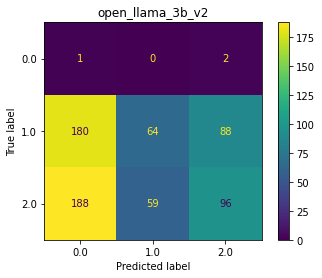

In [27]:
display_confusion_matrix(train[TARGET], train[f"{TARGET}_pred"], os.path.basename(CFG.model_name))

In [28]:
from sklearn.metrics import classification_report
print(classification_report(train[TARGET], train[f"{TARGET}_pred"]))

              precision    recall  f1-score   support

         0.0       0.00      0.33      0.01         3
         1.0       0.52      0.19      0.28       332
         2.0       0.52      0.28      0.36       343

    accuracy                           0.24       678
   macro avg       0.35      0.27      0.22       678
weighted avg       0.52      0.24      0.32       678



## openlm-research/open_llama_7b_v2

In [24]:
start_training(train, "openlm-research/open_llama_7b_v2")

fold 0:


tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Rmse
100,No log,1.337891,1.156250
200,No log,0.692383,0.832031
300,No log,0.538574,0.733887
400,No log,0.562012,0.749512
500,0.574100,0.522949,0.723145
600,0.574100,0.515625,0.718262
700,0.574100,0.489746,0.699707
800,0.574100,0.481934,0.694336


fold 1:


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Rmse
100,No log,0.880371,0.938477
200,No log,0.656250,0.810059
300,No log,0.887695,0.942383
400,No log,0.480957,0.693359
500,0.536700,0.429688,0.655273
600,0.536700,0.436279,0.660645
700,0.536700,0.411621,0.641602
800,0.536700,0.409912,0.640137


In [24]:
start_validating(train, "openlm-research/open_llama_7b_v2")

fold 0:


tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/512k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

fold 1:


Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


cv Solving a communicative task rmse: 1.6435546875


In [25]:
train[f"{TARGET}_pred"] = train[f"{TARGET}_pred"].apply(lambda x: round(x))
train.loc[train[train[f"{TARGET}_pred"] < 0].index, f"{TARGET}_pred"] = 0
train.loc[train[train[f"{TARGET}_pred"] > 2].index, f"{TARGET}_pred"] = 2

<Figure size 576x576 with 0 Axes>

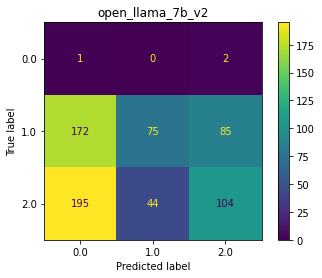

In [26]:
display_confusion_matrix(train[TARGET], train[f"{TARGET}_pred"], os.path.basename(CFG.model_name))

In [27]:
from sklearn.metrics import classification_report
print(classification_report(train[TARGET], train[f"{TARGET}_pred"]))

              precision    recall  f1-score   support

         0.0       0.00      0.33      0.01         3
         1.0       0.63      0.23      0.33       332
         2.0       0.54      0.30      0.39       343

    accuracy                           0.27       678
   macro avg       0.39      0.29      0.24       678
weighted avg       0.58      0.27      0.36       678



## openlm-research/open_llama_13b

In [24]:
start_training(train, "openlm-research/open_llama_13b")

fold 0:


tokenizer_config.json:   0%|          | 0.00/593 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/534k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/330 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

pytorch_model-00001-of-00003.bin:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

pytorch_model-00002-of-00003.bin:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

pytorch_model-00003-of-00003.bin:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Rmse
100,No log,1.232422,1.110352
200,No log,0.759277,0.871582
300,No log,1.004883,1.001953
400,No log,0.903809,0.950684
500,1.414200,0.498779,0.706055
600,1.414200,0.450684,0.671387
700,1.414200,0.366699,0.605469
800,1.414200,0.360840,0.600586
900,1.414200,0.322998,0.568359
1000,0.140400,0.227295,0.476807


fold 1:


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Step,Training Loss,Validation Loss,Rmse
100,No log,1.241211,1.114258
200,No log,0.679688,0.824219
300,No log,0.618164,0.786133
400,No log,0.577637,0.759766
500,1.493700,0.411621,0.641602
600,1.493700,0.317627,0.563477
700,1.493700,0.296143,0.544434
800,1.493700,0.258545,0.508301
900,1.493700,0.253906,0.503906
1000,0.116200,0.268066,0.517578


In [25]:
start_validating(train, "openlm-research/open_llama_13b")

fold 0:


Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

fold 1:


Map:   0%|          | 0/339 [00:00<?, ? examples/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


cv Solving a communicative task rmse: 1.16015625


In [26]:
train[f"{TARGET}_pred"] = train[f"{TARGET}_pred"].apply(lambda x: round(x))
train.loc[train[train[f"{TARGET}_pred"] < 0].index, f"{TARGET}_pred"] = 0
train.loc[train[train[f"{TARGET}_pred"] > 2].index, f"{TARGET}_pred"] = 2

<Figure size 576x576 with 0 Axes>

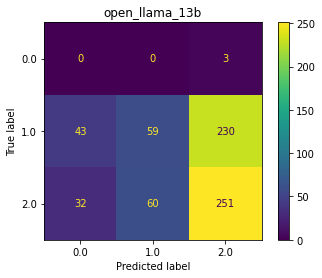

In [27]:
display_confusion_matrix(train[TARGET], train[f"{TARGET}_pred"].apply(lambda x: round(x)), os.path.basename(CFG.model_name))

In [28]:
from sklearn.metrics import classification_report
print(classification_report(train[TARGET], train[f"{TARGET}_pred"]))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         3
         1.0       0.50      0.18      0.26       332
         2.0       0.52      0.73      0.61       343

    accuracy                           0.46       678
   macro avg       0.34      0.30      0.29       678
weighted avg       0.51      0.46      0.44       678

